<a href="https://colab.research.google.com/github/BandooSs/des/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22nir_final_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tables 
!pip install scikit-plot


In [ ]:
!pip install socceraction

In [3]:
import warnings
from socceraction.data.wyscout.loader import _convert_games, _convert_players, _convert_teams, _convert_events, _get_minutes_played
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scikitplot.metrics import plot_calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from xgboost import XGBClassifier, plot_importance

In [4]:
from socceraction.vaep.formula import value

In [5]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [6]:
%matplotlib inline

In [7]:
df_games = pd.read_csv('/content/drive/MyDrive/nir/games.csv', encoding='unicode_escape')
# df_games.tail(10)

In [8]:
df_games_train = df_games[
    df_games['competition_id'] != 412
]

In [9]:
print(df_games_train.shape)

(1561, 8)


In [10]:
df_games_test = df_games[
    df_games['competition_id'] == 412
]

In [ ]:
df_games_test.tail(10)

In [11]:
print(df_games_test.shape)

(380, 8)


In [12]:
df_features = pd.read_csv('/content/drive/MyDrive/nir/features.csv', index_col=0)

In [ ]:
df_features.tail(10)

In [13]:
df_labels = pd.read_csv('/content/drive/MyDrive/nir/labels.csv', index_col=0)

In [ ]:
df_labels.tail(10)

,scores,concedes
2462716,True,False
2462717,True,False
2462718,True,False
2462719,True,False
2462720,True,False
2462721,True,False
2462722,False,True
2462723,False,True
2462724,True,False
2462725,False,False


In [14]:
df_X_train = df_features[df_features['game_id-0'].isin(df_games_train['game_id'].unique())]
df_X_test = df_features[df_features['game_id-0'].isin(df_games_test['game_id'].unique())]
df_y_train = df_labels[ df_labels.index.isin(df_X_train.index) ]
df_y_test = df_labels[ df_labels.index.isin(df_X_test.index) ]

In [ ]:
df_X_train.columns

Index(['game_id-0', 'period_id-0', 'time_seconds-0', 'team_id-0',
       'player_id-0', 'start_x-0', 'start_y-0', 'end_x-0', 'end_y-0',
       'bodypart_id-0', 'type_id-0', 'result_id-0', 'type_name-0',
       'result_name-0', 'bodypart_name-0', 'time_played-0', 'game_id-1',
       'period_id-1', 'time_seconds-1', 'team_id-1', 'player_id-1',
       'start_x-1', 'start_y-1', 'end_x-1', 'end_y-1', 'bodypart_id-1',
       'type_id-1', 'result_id-1', 'type_name-1', 'result_name-1',
       'bodypart_name-1', 'time_played-1', 'game_id-2', 'period_id-2',
       'time_seconds-2', 'team_id-2', 'player_id-2', 'start_x-2', 'start_y-2',
       'end_x-2', 'end_y-2', 'bodypart_id-2', 'type_id-2', 'result_id-2',
       'type_name-2', 'result_name-2', 'bodypart_name-2', 'time_played-2',
       'team-1', 'team-2', 'start_x_norm-0', 'start_y_norm-0',
       'start_distance_to_goal-0', 'start_angle_to_goal-0', 'diff_x-0',
       'diff_y-0', 'distance_covered-0', 'end_x_norm-0', 'end_y_norm-0',
       'en

In [ ]:
df_X_train.shape

(1986196, 88)

In [15]:
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'type_id-0', 'result_id-0',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'type_id-1', 'result_id-1'
    
]

In [16]:
labels = [
    'scores',
    'concedes'
]

In [ ]:
df_X_train[features].shape

(1986196, 12)

In [ ]:
df_y_train['scores'].shape

(1986196,)

In [ ]:
df_X_test[features].shape

(476530, 12)

In [17]:
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=80,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


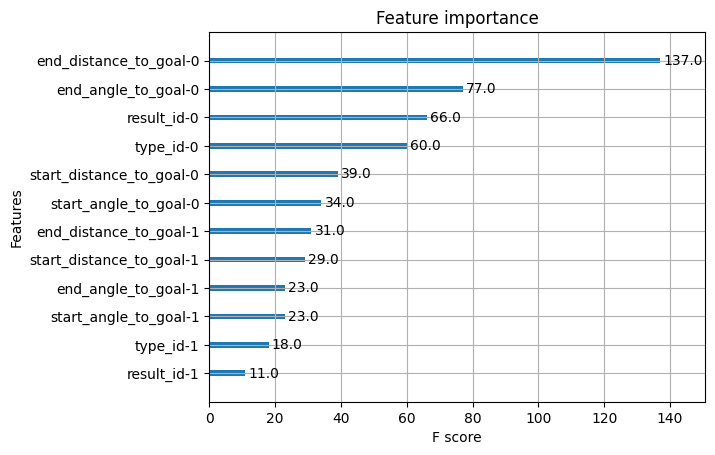

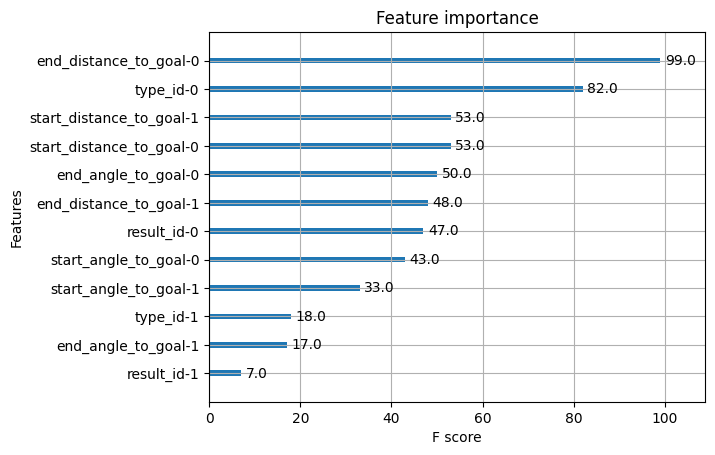

In [18]:
for label in labels:
    plot_importance(models[label])

In [19]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1).reset_index(drop=True)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
predictions.shape

(476530,)

In [20]:
model_for_score=models['scores']

In [21]:
model_for_score.predict( df_X_test[features])

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
Y_test_score=np.array(df_y_test['scores'],dtype=int)

In [23]:
model_for_score.score(df_X_test[features],Y_test_score)

0.9863995970872768

<Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

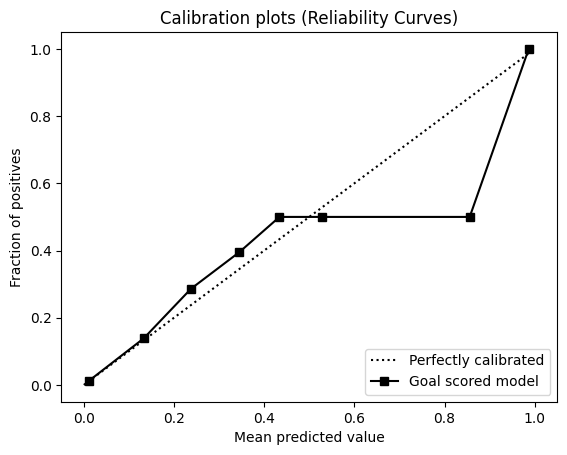

In [54]:
 plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10
)


<Axes: ylabel='Frequency'>

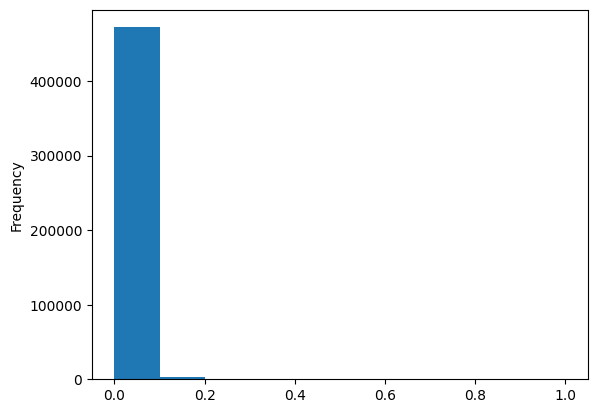

In [ ]:
df_predictions['scores'].plot.hist(
    range=(0, 1),
    bins=10,
)

In [ ]:
import seaborn as sb
from sklearn.metrics import confusion_matrix

In [ ]:
Y_t=model_for_score.predict(df_X_test[features])

In [ ]:
Y_test_score=np.array(df_y_test['scores'],dtype=int)

In [ ]:
Y_t

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
sum(Y_t)

1004

In [ ]:
conf_mx=confusion_matrix(Y_test_score,Y_t)

<Axes: >

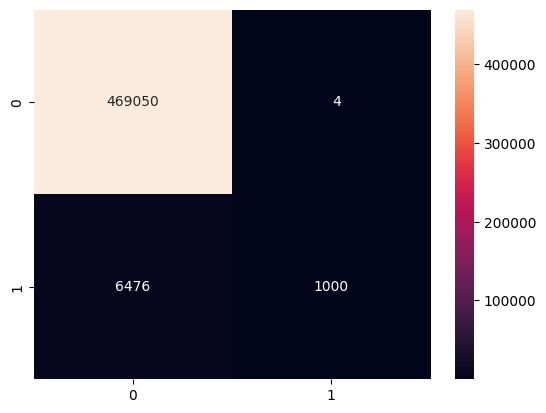

In [ ]:
sb.heatmap(conf_mx,annot=True,fmt='4.0f')

In [ ]:
df_predictions.tail(10)

,scores
476520,0.015850
476521,0.011790
476522,0.010451
476523,0.010420
476524,0.009197
476525,0.014527
476526,0.004346
476527,0.009985
476528,0.011479
476529,0.008921


In [ ]:
df_players = _convert_players(pd.read_csv('/content/drive/MyDrive/nir/players.csv', index_col=0))
df_teams = _convert_teams(pd.read_csv('/content/drive/MyDrive/nir/teams.csv', index_col=0))
df_actions = pd.read_csv('/content/drive/MyDrive/nir/actions.csv', index_col=0)

In [ ]:
ola=pd.read_csv('/content/drive/MyDrive/nir/players.csv', index_col=0)

In [ ]:
ola

,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
passportArea,,,,,,,,,,,,,
"{'name': 'Turkey', 'id': '792', 'alpha3code': 'TUR', 'alpha2code': 'TR'}",78,Harun,NaN,Tekin,4502.0,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687.0
"{'name': 'Senegal', 'id': '686', 'alpha3code': 'SEN', 'alpha2code': 'SN'}",73,Malang,NaN,Sarr,3775.0,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423.0
"{'name': 'France', 'id': '250', 'alpha3code': 'FRA', 'alpha2code': 'FR'}",72,Over,NaN,Mandanda,3772.0,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,NaN,O. Mandanda,NaN
"{'name': 'Senegal', 'id': '686', 'alpha3code': 'SEN', 'alpha2code': 'SN'}",82,Alfred John Momar,NaN,N'Diaye,683.0,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314.0
"{'name': 'France', 'id': '250', 'alpha3code': 'FRA', 'alpha2code': 'FR'}",84,Ibrahima,NaN,Konat\u00e9,2975.0,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"{'name': 'Tunisia', 'id': 788, 'alpha3code': 'TUN', 'alpha2code': 'TN'}",72,Ali,NaN,Ma\u00e2loul,16041.0,1990-01-01,175,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",120839,left,A. Ma\u00e2loul,NaN
"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER', 'alpha2code': 'PE'}",76,Carlos Alberto,NaN,C\u00e1ceda Oyaguez,15591.0,1991-09-27,183,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114736,right,C. C\u00e1ceda,NaN
"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER', 'alpha2code': 'PE'}",78,Miguel Gianpierre,NaN,Araujo Blanco,12072.0,1994-10-24,179,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114908,right,M. Araujo,NaN


In [ ]:
df_actions = ( df_actions.merge( df_players, how='left' )
              .merge( df_teams, how='left')
             )
df_actions.head()

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_name,result_name,bodypart_name,nickname,firstname,lastname,birth_date,player_name,team_name_short,team_name
0,2500089,1,2.763597,1659,9637,52.50,34.00,63.00,30.60,251700146.0,...,pass,success,foot,J. King,Joshua,King,1992-01-15,Joshua King,AFC Bournemouth,AFC Bournemouth
1,2500089,1,4.761353,1659,8351,63.00,30.60,64.05,10.20,251700147.0,...,pass,success,foot,A. Surman,Andrew,Surman,1986-08-20,Andrew Surman,AFC Bournemouth,AFC Bournemouth
2,2500089,1,5.533097,1659,9285,64.05,10.20,72.45,20.40,251700148.0,...,pass,success,foot,C. Daniels,Charlie,Daniels,1986-09-07,Charlie Daniels,AFC Bournemouth,AFC Bournemouth
3,2500089,1,7.707561,1659,239411,72.45,20.40,35.70,19.04,251700161.0,...,pass,success,foot,T. Mings,Tyrone,Mings,1993-03-19,Tyrone Mings,AFC Bournemouth,AFC Bournemouth
4,2500089,1,11.614943,1659,9637,35.70,19.04,30.45,12.24,251700149.0,...,pass,success,foot,J. King,Joshua,King,1992-01-15,Joshua King,AFC Bournemouth,AFC Bournemouth


In [ ]:
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

In [ ]:
game_predictions['scores'].shape


(1229,)

In [ ]:
array_0=np.zeros((1229))

In [ ]:
array_0

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], array_0)
    
    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

AttributeError: ignored

In [ ]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [ ]:
df_values.tail(100)

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,lastname,birth_date,player_name,team_name_short,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
2462626,2576338,2,2035.418947,3193,3548,33.60,46.24,45.15,23.12,253566891.0,...,Rossi,1987-02-01,Giuseppe Rossi,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462627,2576338,2,2038.941423,3193,206318,45.15,23.12,31.50,21.76,253566892.0,...,Biraschi,1994-07-02,Davide Biraschi,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462628,2576338,2,2042.050278,3193,70974,31.50,21.76,25.20,9.52,253566893.0,...,Pican\u00e7o Medeiros,1994-07-10,Iuri Jos\u00e9 Pican\u00e7o Medeiros,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462629,2576338,2,2053.487324,3185,354552,61.95,55.08,39.90,42.84,253566940.0,...,Edera,1997-01-09,Simone Edera,Torino,Torino FC,NaN,NaN,NaN,NaN,NaN
2462630,2576338,2,2060.633711,3193,206318,39.90,40.12,14.70,44.20,253566902.0,...,Biraschi,1994-07-02,Davide Biraschi,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462721,2576338,2,2630.727964,3193,20749,66.15,0.00,59.85,12.92,253567059.0,...,Bertolacci,1991-01-11,Andrea Bertolacci,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462722,2576338,2,2633.465692,3193,0,59.85,12.92,42.00,14.96,NaN,...,NaN,NaT,NaN,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462723,2576338,2,2636.203420,3193,0,42.00,14.96,39.90,12.92,253567274.0,...,NaN,NaT,NaN,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462724,2576338,2,2637.177535,3193,116269,39.90,12.92,38.85,17.00,253567068.0,...,Laxalt Su\u00e1rez,1993-02-07,Diego Sebasti\u00e1n Laxalt Su\u00e1rez,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_values.columns

Index(['game_id', 'period_id', 'time_seconds', 'team_id', 'player_id',
       'start_x', 'start_y', 'end_x', 'end_y', 'original_event_id',
       'bodypart_id', 'type_id', 'result_id', 'action_id', 'type_name',
       'result_name', 'bodypart_name', 'nickname', 'firstname', 'lastname',
       'birth_date', 'player_name', 'team_name_short', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [ ]:
df_values

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,lastname,birth_date,player_name,team_name_short,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,1694390,1,1.255990,4418,26010,52.50,32.64,55.65,34.00,88178642.0,...,Giroud,1986-09-30,Olivier Giroud,France,France,NaN,NaN,NaN,NaN,NaN
1,1694390,1,2.351908,4418,3682,55.65,34.00,61.95,32.64,88178643.0,...,Griezmann,1991-03-21,Antoine Griezmann,France,France,NaN,NaN,NaN,NaN,NaN
2,1694390,1,3.241028,4418,31528,61.95,32.64,71.40,23.80,88178644.0,...,Kant\u00e9,1991-03-29,N'Golo Kant\u00e9,France,France,NaN,NaN,NaN,NaN,NaN
3,1694390,1,6.033681,4418,7855,71.40,23.80,11.55,4.08,88178645.0,...,Koscielny,1985-09-10,Laurent Koscielny,France,France,NaN,NaN,NaN,NaN,NaN
4,1694390,1,27.053006,4418,7915,15.75,0.00,7.35,10.88,88178648.0,...,Evra,1981-05-15,Patrice Evra,France,France,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462721,2576338,2,2630.727964,3193,20749,66.15,0.00,59.85,12.92,253567059.0,...,Bertolacci,1991-01-11,Andrea Bertolacci,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462722,2576338,2,2633.465692,3193,0,59.85,12.92,42.00,14.96,NaN,...,NaN,NaT,NaN,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462723,2576338,2,2636.203420,3193,0,42.00,14.96,39.90,12.92,253567274.0,...,NaN,NaT,NaN,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN
2462724,2576338,2,2637.177535,3193,116269,39.90,12.92,38.85,17.00,253567068.0,...,Laxalt Su\u00e1rez,1993-02-07,Diego Sebasti\u00e1n Laxalt Su\u00e1rez,Genoa,Genoa CFC,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_ranking = (df_values[['player_id', 'team_name', 'nickname', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'nickname'])
    .agg(vaep_count=('vaep_value', 'count'), 
         vaep_mean=('vaep_value', 'mean'),
         vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [ ]:
df_ranking

,player_id,team_name,nickname,vaep_count,vaep_mean,vaep_sum
0,107,Stoke City FC,E. Pieters,1700,0.010270,17.458649
1,8313,West Ham United FC,P. Zabaleta,2012,0.008260,16.618486
2,8653,Leicester City FC,H. Maguire,2251,0.007282,16.391367
3,25854,Stoke City FC,K. Zouma,1539,0.010268,15.803068
4,210044,Tottenham Hotspur FC,E. Dier,2609,0.005827,15.202197
...,...,...,...,...,...,...
3599,7944,Everton FC,W. Rooney,1496,-0.001554,-2.324175
3600,8903,Watford FC,T. Deeney,620,-0.003867,-2.397755
3601,12829,Leicester City FC,J. Vardy,740,-0.004124,-3.052102
3602,54,Tottenham Hotspur FC,C. Eriksen,2958,-0.001073,-3.173445


In [ ]:
df_player_games = pd.read_csv('/content/drive/MyDrive/nir/player_games.csv', index_col=0)
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [ ]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [ ]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [ ]:
MIN_THRESHOLD = 450

In [ ]:
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]

In [ ]:
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)
df_ranking_p90

,player_id,team_name,nickname,vaep_count,vaep_mean,vaep_sum,minutes_played,vaep_rating,actions_p90
79,9280,Huddersfield Town FC,S. Malone,897,0.012253,10.991324,1216,0.813503,66.389803
259,486252,Crystal Palace FC,A. Wan-Bissaka,429,0.011697,5.018077,661,0.683248,58.411498
315,217078,Leicester City FC,D. Amartey,352,0.010871,3.826613,516,0.667432,61.395349
194,9164,Burnley FC,C. Taylor,607,0.011701,7.102258,1012,0.631624,53.982213
202,279717,Arsenal FC,A. Maitland-Niles,805,0.008598,6.921007,991,0.628548,73.107972
...,...,...,...,...,...,...,...,...,...
3599,8959,AFC Bournemouth,J. Stanislas,776,-0.001788,-1.387541,1369,-0.091219,51.015340
3600,8416,Brighton & Hove Albion FC,G. Murray,900,-0.002620,-2.358176,2317,-0.091599,34.958999
2188,7944,Everton FC,W. Rooney,1496,-0.002026,-3.030731,2665,-0.102351,50.521576
3601,8903,Watford FC,T. Deeney,620,-0.003941,-2.443525,1977,-0.111238,28.224583


In [ ]:
df_ranking_p90.shape

(2573, 9)

In [ ]:

mu=df_ranking_p90[df_ranking_p90['team_name']=='Manchester United FC']
mu

,player_id,team_name,nickname,vaep_count,vaep_mean,vaep_sum,minutes_played,vaep_rating,actions_p90
178,3413,Manchester United FC,Ander Herrera,1264,0.005785,7.311731,1336,0.492557,85.149701
25,7938,Manchester United FC,A. Valencia,2401,0.005535,13.290680,2915,0.410347,74.130360
329,8135,Manchester United FC,L. Shaw,720,0.004946,3.560963,840,0.381532,77.142857
318,101652,Manchester United FC,M. Rojo,465,0.008200,3.812917,924,0.371388,45.292208
406,21095,Manchester United FC,M. Darmian,316,0.007786,2.460519,616,0.359491,46.168831
55,7939,Manchester United FC,A. Young,2117,0.005622,11.901106,3095,0.346074,61.560582
156,7918,Manchester United FC,P. Jones,1313,0.006041,7.931581,2277,0.313501,51.897233
51,70122,Manchester United FC,N. Mati\u0107,3112,0.003868,12.036180,3616,0.299573,77.455752
73,7936,Manchester United FC,P. Pogba,2207,0.005073,11.196868,3488,0.288910,56.946674
213,71703,Manchester United FC,V. Lindel\u00f6f,934,0.006836,6.384926,2050,0.280314,41.004878


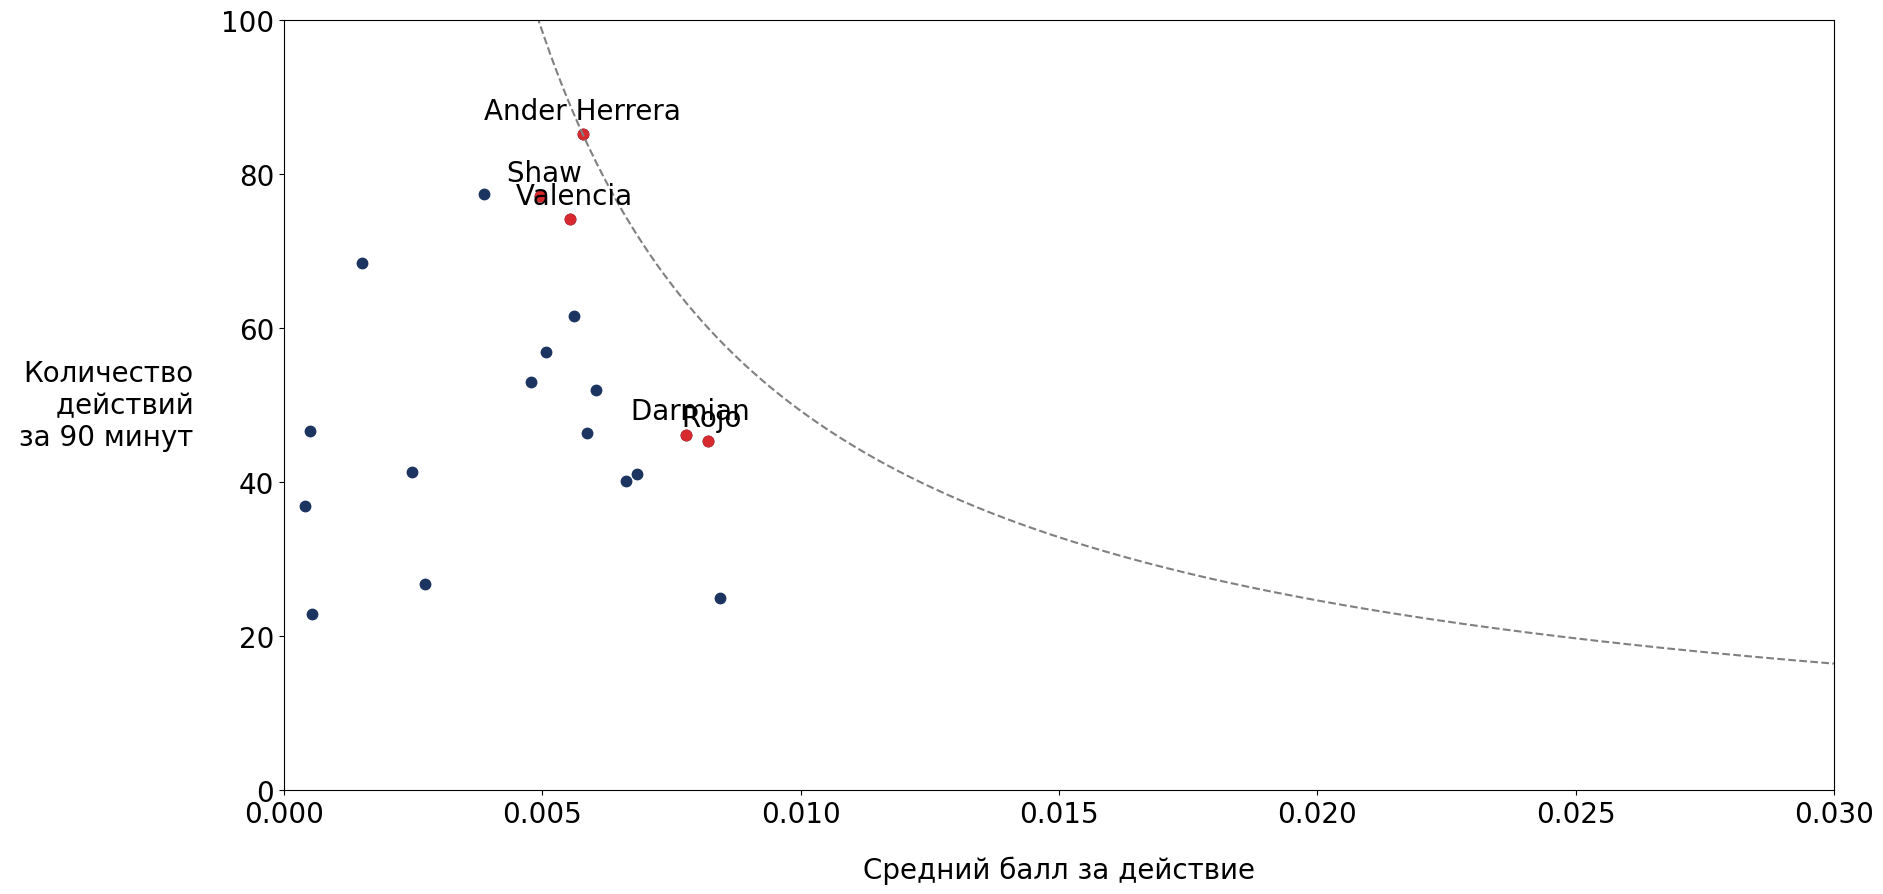

In [ ]:
mu=df_ranking_p90[df_ranking_p90['team_name']=='Manchester United FC']
plt.figure(figsize=(20, 10))
x = list(mu['vaep_mean'])
y = list(mu['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(mu['vaep_mean'][0:5])
y_best = list(mu['actions_p90'][0:5])
names = list(mu['nickname'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.03)
plt.ylim(0, 100)
plt.xlabel('Средний балл за действие', labelpad=20, fontsize=20)
plt.ylabel('Количество\n действий\n за 90 минут', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

In [ ]:
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'nickname', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])
for result in ['success', 'fail']:
    df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90
df_risk.head()

,player_id,nickname,team_name,success,fail,minutes_played
0,12,K. Omeruo,Nigeria,0.000000,0.000000,190
1,33,J. Cillessen,FC Barcelona,0.000000,0.000000,93
2,36,T. Alderweireld,Belgium,0.000000,0.000000,2304
3,36,T. Alderweireld,Tottenham Hotspur FC,0.161878,0.065873,2304
4,38,D. Blind,Manchester United FC,-0.052397,-0.003915,387


In [ ]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')

,player_id,nickname,team_name,success,fail,minutes_played,vaep_rating
755,9532,S. Berahino,Stoke City FC,0.068836,-0.144109,548,-0.075273
728,8981,W. Hughes,Watford FC,0.265576,-0.119990,1046,0.145586
751,9414,M. Phillips,West Bromwich Albion FC,0.169174,-0.101309,2234,0.067864
1990,61961,B. Kayal,Brighton & Hove Albion FC,0.160056,-0.092607,809,0.067449
1854,41174,M. Lanzini,West Ham United FC,0.179403,-0.083466,2191,0.095936
...,...,...,...,...,...,...,...
2922,258162,Renato Sanches,Swansea City AFC,0.209528,0.223846,1179,0.433374
3236,339789,Mikel Merino,Newcastle United FC,0.110725,0.225013,1441,0.335738
51,340,Cuco Martina,Everton FC,0.300234,0.225946,1933,0.526180
2974,268776,W. Hoedt,Southampton FC,0.110071,0.226703,2702,0.336774


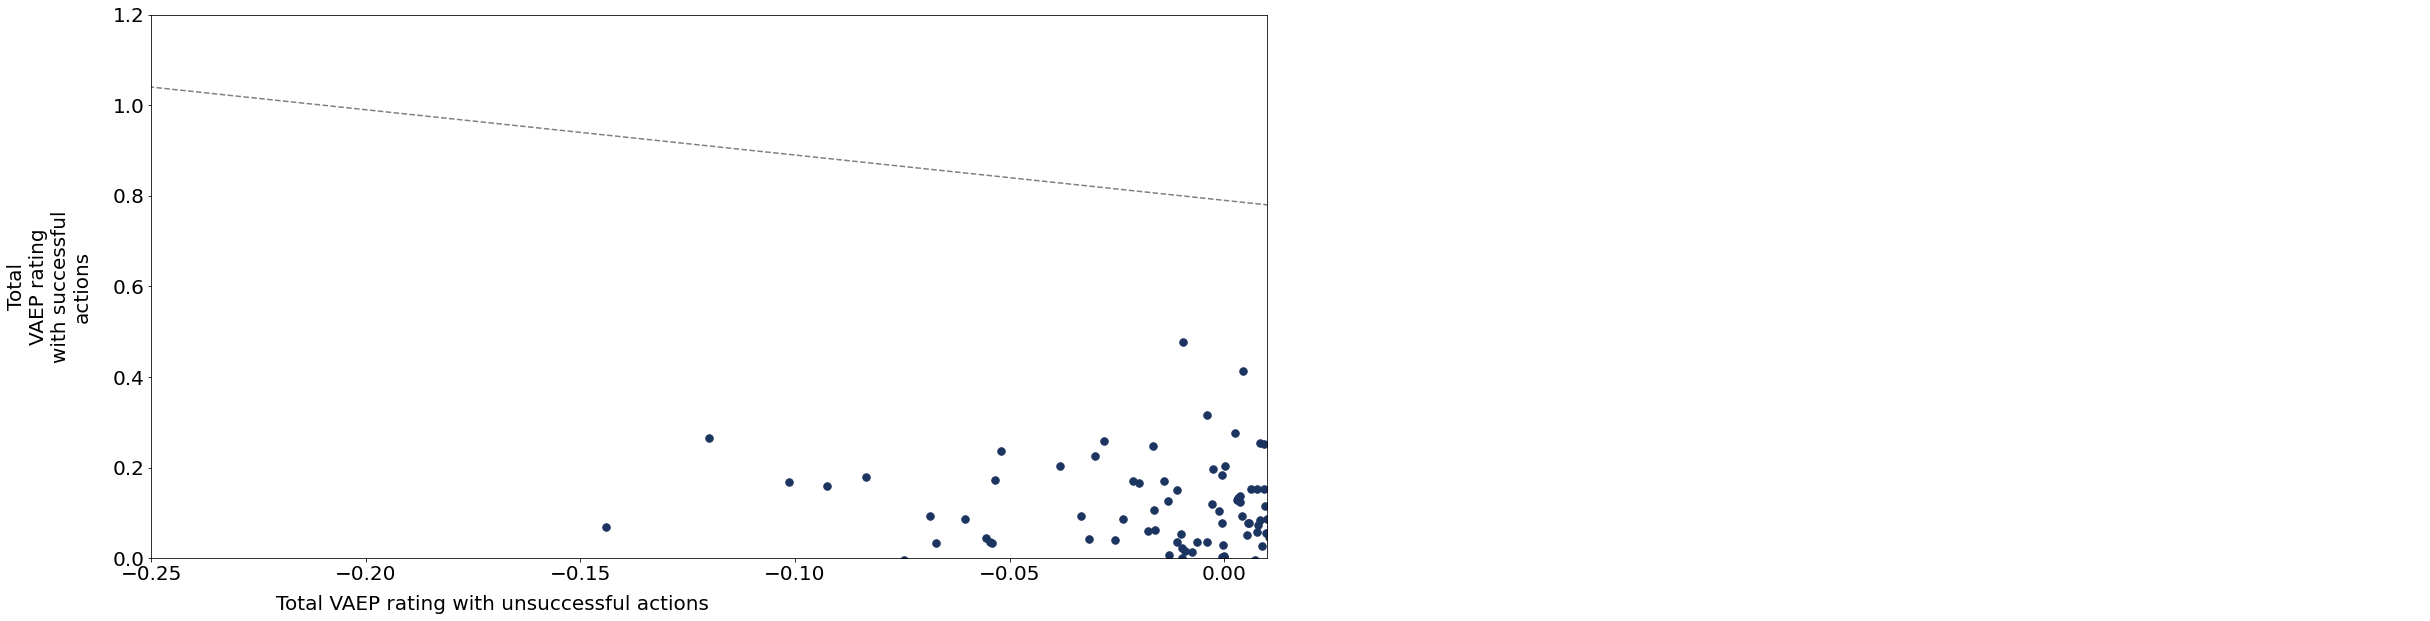

In [ ]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:5])
y_best = list(df_risk['success'][0:5])
names = list(df_risk['nickname'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

best_player = x[0] + y[0]
yi = np.arange(0.1, 2, 0.1)
xi = [best_player - i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.25, 0.01)
plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

In [ ]:
df_rating_action = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'nickname', 'team_name'],
                                              columns=['type_name'], aggfunc=np.sum,
                                              fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in df_values['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

In [ ]:
df_rating_action[df_rating_action['minutes_played']>MIN_THRESHOLD].sort_values('pass', ascending=False).head(10)

,player_id,nickname,team_name,bad_touch,clearance,corner_crossed,corner_short,cross,dribble,foul,...,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
2823,240070,H. Winks,Tottenham Hotspur FC,0.0,0.097295,0.000000,0.000000,-0.004144,-0.005771,0.001226,...,0.0,0.444641,-0.000563,0.000000,0.000000,-0.005072,-0.001288,0.000155,5.220069,834
736,9164,C. Taylor,Burnley FC,0.0,0.035352,0.000000,0.000000,0.016853,-0.018207,0.005239,...,0.0,0.422163,0.000000,0.000000,0.000000,0.003949,0.003184,0.071683,6.882597,1012
1742,29640,M. Lemina,Southampton FC,0.0,0.006909,0.000000,0.000000,0.003286,0.007345,0.012785,...,0.0,0.417759,0.003457,0.000000,0.000000,0.001029,0.002389,0.002909,10.931047,1846
743,9280,S. Malone,Huddersfield Town FC,0.0,0.103607,0.000000,0.000000,0.008962,0.014894,0.031259,...,0.0,0.394458,0.002826,0.000000,0.000000,0.000000,0.011675,0.173188,10.694452,1216
568,8142,J. Puncheon,Crystal Palace FC,0.0,0.008227,-0.060533,0.000000,0.009812,0.105845,-0.116103,...,0.0,0.393494,0.010584,0.000000,0.000000,0.000829,0.003123,0.005358,2.710438,617
2922,258162,Renato Sanches,Swansea City AFC,0.0,0.000389,-0.027805,-0.008045,0.025171,-0.014776,0.008856,...,0.0,0.386182,0.007533,0.002797,0.000000,-0.000296,0.007251,0.005603,5.682752,1179
406,4908,Alberto Moreno,Liverpool FC,0.0,0.022458,-0.008981,0.000000,0.075929,-0.068334,0.008761,...,0.0,0.359421,0.004277,0.000668,0.000000,0.000402,0.003428,0.064878,8.117141,1359
189,3436,Javi Manquillo,Newcastle United FC,0.0,0.014406,0.000000,0.000000,-0.048969,0.000827,0.011586,...,0.0,0.346399,0.000081,0.000000,0.000000,0.001908,0.017344,0.164399,11.827771,1872
876,14808,\u0130. G\u00fcndo\u011fan,Manchester City FC,0.0,0.029191,-0.004277,-0.020326,0.000134,0.005512,0.004500,...,0.0,0.313704,0.002505,-0.000194,-0.040886,0.002141,0.006846,0.000666,7.561334,1693
833,14748,A. R\u00fcdiger,Chelsea FC,0.0,0.026156,0.000000,0.000000,0.001897,0.005661,0.008591,...,0.0,0.305460,-0.001943,0.000000,0.000000,0.000916,0.010422,0.002786,12.417118,2586
